**Задача**

1) Создать синтетический набор данных используя открытую LLM для решения поставленной задачи

2) Обучить модель классификации текста на основе созданного набора данных используя трансформерную модель энкодер (например BERT)

**Генерация данных**

Требования к данным:  

1)Набор даных должен представлять диалоги клиентов с поддержкой на тему банковских услуг (кредиты, денежные переводы и т.д).

2)Набор данных должен быть создан для решения задачи классификации последнего сообщения пользователя в диалоге - (класс - текущий вопрос пользователя по которому будет выдаваться некоторые заранее заготовленный ответ)

3)В Наборе данных должно быть не менее 15 классов (больше можно), выполняющий имеет свободу выбора сам составить предполагаемые классы сообщений или же сгенерировать их. Для каждого класса нужно сгенерировать не менее 20 различны примеров для обучения и 10 для теста.

4) Формат данных:

{"label": 'transfer_status',

"dialog":

"user: Привет! можете помочь мне ?

assistant: Здравствуйте! В чем ваш вопрос?

user: Мой перевод все еше не пришел, какой у него cтатус ?"}

5) Напоминание, класс определяется именно для последнего сообщения в контексте диалога, а не для последнего сообщения в отдельности или же диалога в целом.

**Что поможет**

1) Все модели и гайды искать на https://huggingface.co/

2) Модель можно запустить как через transformers, так и через специализированные движки (приветствуется ) llama.cpp / VLLM

3)Ресурсов Colab или же Kaggle достаточно для генерации за 1 итерацию.

**Обучение классификатора**

1) Достаточный вариант - реализовать обучение через Trainer из huggingface transformers, на портале есть множество гайдов в том числе для решения задачи классификации текста с помощью моделей энкодеров (например BERT)

2)При желании можно показать свои навыки в написании кастомных циклов обучения, не используя готовый класс Trainer

3)Желательно использовать transformers + pytorch, другие варианты (например через tensorflow также будут проверяться, но этот фреймворк редко используется в практике проверяющих)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from io import StringIO

c:\Users\makar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('dataset.txt', 'r', encoding='utf-8') as file:
    data_content = file.read()

data_io = StringIO(data_content)

data = pd.read_json(data_io)


In [3]:
unique_labels = data['label'].unique()
label_to_code = {label: code for code, label in enumerate(unique_labels)}
data['label'] = data['label'].map(label_to_code)

In [4]:
print(data.shape)
data = data.drop_duplicates()

print(data.shape)


(539, 2)
(525, 2)


In [5]:
train_data = []
test_data = []

for label in data['label'].unique():
    class_data = data[data['label'] == label]
    train_samples, test_samples = train_test_split(class_data, test_size=0.33, random_state=42)
    train_data.append(train_samples)
    test_data.append(test_samples)

train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

In [6]:
data[data['label'] == 0].head(5)

,label,dialog
0,0,user: Привет! Какой статус моего перевода?
1,0,user: Здравствуйте! Когда я могу ожидать перевод?
2,0,"user: Мой перевод задерживается, что происходит?"
3,0,"user: Я не получил перевод, можете проверить?"
4,0,user: Как долго еще ждать перевод?


In [7]:
class_counts = test_data['label'].value_counts()

print(class_counts)

label
2     12
3     12
4     12
0     11
1     11
5     11
6     11
7     11
8     11
9     11
10    11
11    11
12    11
13    11
14    11
15    11
Name: count, dtype: int64


In [8]:
train_data.shape

(346, 2)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = CustomDataset(train_data['dialog'].tolist(), train_data['label'].tolist(), tokenizer, max_length=128)
test_dataset = CustomDataset(test_data['dialog'].tolist(), test_data['label'].tolist(), tokenizer, max_length=128)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data['label'].unique()))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=0.0002,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

  5%|▍         | 10/220 [00:30<10:57,  3.13s/it]

{'loss': 2.7886, 'grad_norm': 8.25777530670166, 'learning_rate': 1e-05, 'epoch': 0.45}


  9%|▉         | 20/220 [01:04<11:19,  3.40s/it]

{'loss': 2.8186, 'grad_norm': 12.247207641601562, 'learning_rate': 2e-05, 'epoch': 0.91}


 14%|█▎        | 30/220 [01:37<10:38,  3.36s/it]

{'loss': 2.7332, 'grad_norm': 13.262642860412598, 'learning_rate': 3e-05, 'epoch': 1.36}


 18%|█▊        | 40/220 [02:10<09:46,  3.26s/it]

{'loss': 2.705, 'grad_norm': 6.306149959564209, 'learning_rate': 4e-05, 'epoch': 1.82}


 23%|██▎       | 50/220 [02:41<09:07,  3.22s/it]

{'loss': 2.7274, 'grad_norm': 5.164916515350342, 'learning_rate': 5e-05, 'epoch': 2.27}


 27%|██▋       | 60/220 [03:15<08:57,  3.36s/it]

{'loss': 2.5874, 'grad_norm': 8.385963439941406, 'learning_rate': 6e-05, 'epoch': 2.73}


 32%|███▏      | 70/220 [03:47<08:06,  3.24s/it]

{'loss': 2.5794, 'grad_norm': 19.83440589904785, 'learning_rate': 7e-05, 'epoch': 3.18}


 36%|███▋      | 80/220 [04:21<07:47,  3.34s/it]

{'loss': 2.5383, 'grad_norm': 8.409761428833008, 'learning_rate': 8e-05, 'epoch': 3.64}


 41%|████      | 90/220 [04:53<06:45,  3.12s/it]

{'loss': 2.41, 'grad_norm': 8.126541137695312, 'learning_rate': 9e-05, 'epoch': 4.09}


 45%|████▌     | 100/220 [05:27<06:53,  3.44s/it]

{'loss': 2.2883, 'grad_norm': 8.456411361694336, 'learning_rate': 0.0001, 'epoch': 4.55}


 50%|█████     | 110/220 [06:00<05:38,  3.07s/it]

{'loss': 2.2031, 'grad_norm': 7.525096893310547, 'learning_rate': 0.00011000000000000002, 'epoch': 5.0}


 55%|█████▍    | 120/220 [06:34<05:37,  3.37s/it]

{'loss': 1.7631, 'grad_norm': 7.283915042877197, 'learning_rate': 0.00012, 'epoch': 5.45}


 59%|█████▉    | 130/220 [07:08<05:05,  3.39s/it]

{'loss': 1.6403, 'grad_norm': 7.985880374908447, 'learning_rate': 0.00013000000000000002, 'epoch': 5.91}


 64%|██████▎   | 140/220 [07:40<04:27,  3.35s/it]

{'loss': 1.2775, 'grad_norm': 10.869354248046875, 'learning_rate': 0.00014, 'epoch': 6.36}


 68%|██████▊   | 150/220 [08:13<03:49,  3.28s/it]

{'loss': 1.1389, 'grad_norm': 5.394808292388916, 'learning_rate': 0.00015000000000000001, 'epoch': 6.82}


 73%|███████▎  | 160/220 [08:45<03:12,  3.20s/it]

{'loss': 0.8146, 'grad_norm': 4.2445783615112305, 'learning_rate': 0.00016, 'epoch': 7.27}


 77%|███████▋  | 170/220 [09:17<02:43,  3.27s/it]

{'loss': 0.8599, 'grad_norm': 5.891294479370117, 'learning_rate': 0.00017, 'epoch': 7.73}


 82%|████████▏ | 180/220 [09:49<02:08,  3.22s/it]

{'loss': 0.7842, 'grad_norm': 7.169764995574951, 'learning_rate': 0.00018, 'epoch': 8.18}


 86%|████████▋ | 190/220 [10:23<01:40,  3.36s/it]

{'loss': 0.5889, 'grad_norm': 9.728352546691895, 'learning_rate': 0.00019, 'epoch': 8.64}


 91%|█████████ | 200/220 [10:55<01:02,  3.12s/it]

{'loss': 0.6347, 'grad_norm': 5.034736156463623, 'learning_rate': 0.0002, 'epoch': 9.09}


 95%|█████████▌| 210/220 [11:28<00:33,  3.32s/it]

{'loss': 0.8038, 'grad_norm': 15.599231719970703, 'learning_rate': 0.0001, 'epoch': 9.55}


100%|██████████| 220/220 [12:00<00:00,  3.01s/it]

{'loss': 0.4205, 'grad_norm': 6.276097297668457, 'learning_rate': 0.0, 'epoch': 10.0}


100%|██████████| 220/220 [12:01<00:00,  3.28s/it]

{'train_runtime': 721.6616, 'train_samples_per_second': 4.794, 'train_steps_per_second': 0.305, 'train_loss': 1.777531571821733, 'epoch': 10.0}


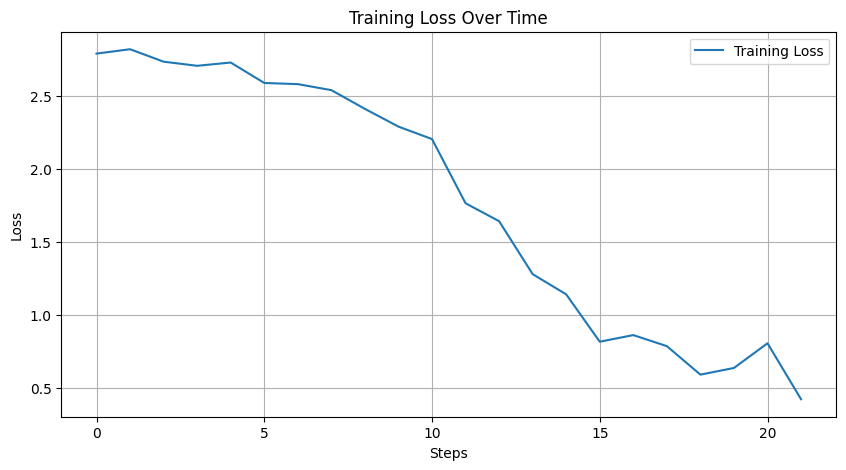

In [12]:
import matplotlib.pyplot as plt
from transformers import TrainerCallback

class LogLossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and 'loss' in logs:
            self.losses.append(logs['loss'])

log_loss_callback = LogLossCallback()

trainer.add_callback(log_loss_callback)
trainer.train()

plt.figure(figsize=(10, 5))
plt.plot(log_loss_callback.losses, label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [13]:
trainer.evaluate()

100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


{'eval_loss': 0.5842763185501099,
 'eval_runtime': 9.5465,
 'eval_samples_per_second': 18.75,
 'eval_steps_per_second': 1.257,
 'epoch': 10.0}

In [14]:
predictions = trainer.predict(test_dataset)

y_pred = predictions.predictions.argmax(-1)


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


In [15]:
y_true = test_data['label'].tolist()

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7653631284916201
Precision: 0.7694190951592268
Recall: 0.7653631284916201
F1 Score: 0.7494882504368204


**Как представить результат ?**

Jupyter notebook, желательно один с обоими частями задачи и обязательно содержащий наглядную демонстрацию результатов - примеры сгенерированных диалогов для каждого класса, обучающие и тестовые метрики оубчения классификатора.

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = trainer.model
new_dialog = "user: Когда мне одобрят кредит?"

inputs = tokenizer(new_dialog, return_tensors='pt', padding=True, truncation=True, max_length=128)

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits

probabilities = torch.nn.functional.softmax(logits, dim=-1)

predicted_class = torch.argmax(probabilities, dim=-1)

print(f"Предсказанный класс: {predicted_class.item()}")
print(f"Вероятности для каждого класса: {probabilities.numpy()}")

Предсказанный класс: 5
Вероятности для каждого класса: [[3.2629645e-03 4.5582145e-01 9.2210359e-04 4.5499713e-03 1.4689097e-03
  5.0742990e-01 2.7056255e-03 7.6329935e-04 1.8608627e-03 1.1818373e-03
  1.0882800e-03 8.1639923e-03 1.5746037e-04 7.5342888e-03 4.6512077e-04
  2.6238617e-03]]


In [19]:
print("Карта соответствий:")
for label, code in label_to_code.items():
    print(f"Класс: {label}, Код: {code}")

Карта соответствий:
Класс: transfer_status, Код: 0
Класс: loan_query, Код: 1
Класс: account_balance, Код: 2
Класс: credit_card_limit, Код: 3
Класс: money_transfer, Код: 4
Класс: loan_approval, Код: 5
Класс: payment_issue, Код: 6
Класс: bank_branch_hours, Код: 7
Класс: credit_card_application, Код: 8
Класс: transaction_history, Код: 9
Класс: savings_account, Код: 10
Класс: loan_interest_rate, Код: 11
Класс: debit_card_issue, Код: 12
Класс: financial_advice, Код: 13
Класс: insurance_query, Код: 14
Класс: credit_score, Код: 15
